In [1]:
%matplotlib inline

In [2]:
from gfcat_utils import *

In [3]:
import numpy as np
from astropy.io import fits as pyfits
from astropy import wcs as pywcs
from astropy.visualization import simple_norm, ZScaleInterval
import imageio
from matplotlib.patches import Circle, Rectangle

In [4]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [10]:
band = 'NUV'
b = band[0].lower()+'d'
for eclipse in [8915,]:#7068,3090,9204,13461,14256,21066,32394,41726,
                #5024,12958,13642,15133,27702,38424,
                #42161]:
    e = str(eclipse).zfill(5)
    print(f"Processing e{e}...")
    tmpdir = "/Users/cm/GFCAT/gfcat/tmp/"
    lc_filename = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-{b}-30s-photom-12_8.csv"
    fn = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-{b}-full-rice.fits"
    fn_mov = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-{b}-30s-rice.fits"
    lc = parse_lightcurves(lc_filename)

    x = np.array([source['xcenter'] for source in lc])
    y = np.array([source['ycenter'] for source in lc])
    cps = np.array([np.nanmean(source['cps']) for source in lc])

    variables = screen_gfcat([eclipse],band=band,aper_radius=12.8,photdir="/Users/cm/github/gphoton_working/test_data")
    print(variables)

    #if not len(variables):
    #    continue
    movmap,flagmap,edgemap,wcs,tranges,exptimes=read_image(fn_mov,hdunum=1)
    movmap[np.where(np.isinf(movmap))]=0 # because it pops out with inf values... IDK
    movmap[np.where(movmap<0)]=0
    
    for source_ix in [37655]:#variables[eclipse]:        
        assert len(lc[source_ix]['cps'])==np.shape(movmap)[0]
        imgx,imgy = lc[source_ix]['xcenter'],lc[source_ix]['ycenter']
        
        if not os.path.exists(f'{tmpdir}/e{e}/'):
            os.makedirs(f'{tmpdir}/e{e}/')

        imsz = np.shape(movmap[0])

        # crop on the subframe
        boxsz = 200
        x1, x2, y1, y2 = (max(int(imgy - boxsz),0),
                          min(int(imgy + boxsz),imsz[0]),
                          max(int(imgx - boxsz),0),
                          min(int(imgx + boxsz),imsz[1]))

        # crop on the full frame
        x1_,x2_,y1_,y2_ = (max(int(imsz[0]/2-imsz[0]/2),0),
                           min(int(imsz[0]/2+imsz[0]/2),imsz[0]),
                           max(int(imsz[1]/2-imsz[0]/2),0),
                           min(int(imsz[1]/2+imsz[0]/2),imsz[1]))

        gs = gridspec.GridSpec(nrows=4, ncols=6)#, height_ratios=[1, 1, 2])

        # write individual frames of the animated gif
        for i,frame in enumerate(movmap): # probably eliminate the first / last frame, which always has lower exposure
            fig = plt.figure(figsize=(12,9));
            fig.tight_layout()
            ax = fig.add_subplot(gs[:3,:3])
            opacity = (edgemap[i]+flagmap[i])/2
            # M, N, 3 or M, N, 4
            ax.imshow(edgemap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Reds",alpha=opacity[x1_:x2_,y1_:y2_])
            ax.imshow(flagmap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Blues",alpha=opacity[x1_:x2_,y1_:y2_])
            ax.imshow(np.stack([ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                                 ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                                 ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                                 1-opacity[x1_:x2_,y1_:y2_]],axis=2),origin="lower")
            ax.set_xticks([])
            ax.set_yticks([])
            rect = Rectangle((y1-y1_, x1-x1_), 2*boxsz, 2*boxsz, linewidth=1, edgecolor='y', facecolor='none',ls='solid')
            ax.add_patch(rect)

            ax = fig.add_subplot(gs[:3,3:])
            ax.imshow(edgemap[i][x1:x2,y1:y2],origin="lower",cmap="Reds",alpha=opacity[x1:x2,y1:y2])
            ax.imshow(flagmap[i][x1:x2,y1:y2],origin="lower",cmap="Blues",alpha=opacity[x1:x2,y1:y2])
            ax.imshow(np.stack([ZScaleInterval()(frame[x1:x2,y1:y2]),
                                 ZScaleInterval()(frame[x1:x2,y1:y2]),
                                 ZScaleInterval()(frame[x1:x2,y1:y2]),
                                 1-opacity[x1:x2,y1:y2]],axis=2),origin="lower")
            ax.set_xticks([])
            ax.set_xticks([])
            ax.set_yticks([])
            circ = Circle((boxsz,boxsz),20,linewidth=1,edgecolor='y',facecolor='none',ls='solid')
            ax.add_patch(circ)

            ax = fig.add_subplot(gs[3:,:])
            ax.set_xticks([])
            t = np.arange(len(lc[source_ix]['cps']))
            cps = lc[source_ix]['cps']
            cps_err = lc[source_ix]['cps_err']
            min_i,max_i=np.argmin(cps),np.argmax(cps)
            ax.vlines(t[i],cps[min_i]-3*cps_err[min_i],
                           cps[max_i]+3*cps_err[max_i],ls='dotted')
            ax.scatter(t[i],cps[i],c='y',s=100,marker='o')
            ax.errorbar(t,cps,yerr=cps_err*3,fmt='k.-')
            
            plt.savefig(f'{tmpdir}/e{e}/e{e}-{b}-30s-{str(i).zfill(2)}-{str(source_ix).zfill(5)}.png',dpi=100)
            plt.close()
        
        cleanup=True
        n_frames = np.shape(movmap)[0]
        # write the animated gif
        gif_fn = f'{tmpdir}/e{e}/e{e}-{b}-30s-{str(source_ix).zfill(5)}.gif'
        print(f"writing {gif_fn}")
        with imageio.get_writer(gif_fn, mode='I', fps=6) as writer:
            for i in np.arange(n_frames):
                frame_fn = f'{tmpdir}/e{e}/e{e}-{b}-30s-{str(i).zfill(2)}-{str(source_ix).zfill(5)}.png'
                image = imageio.imread(frame_fn)
                writer.append_data(image)
                if cleanup:
                    os.remove(frame_fn)
                    

Processing e08915...

  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'id': []}

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]


{}

writing /Users/cm/GFCAT/gfcat/tmp//e08915/e08915-nd-30s-37655.gif

(0.0, 350.0)

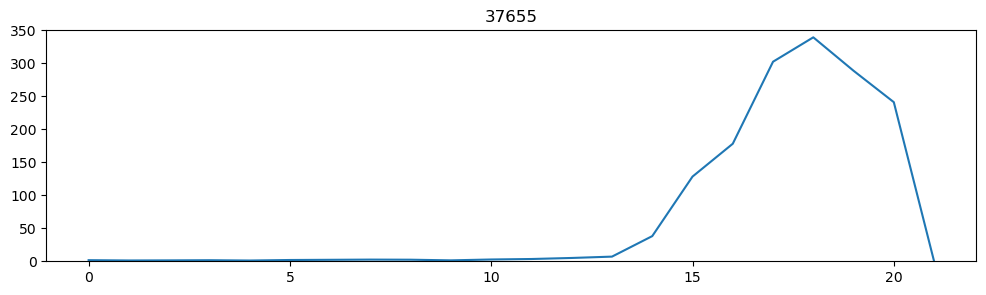

In [6]:
i = 37655
plt.figure(figsize=(12,3))
plt.title(i)
plt.plot(lc[i]['cps'])
plt.ylim([0,350])

In [7]:
i = 37655
lc = parse_lightcurves(lc_filename)[i]
expt_fn = lc_filename.split('photom')[0]+'exptime.csv'
expt = parse_exposure_time(expt_fn)

if not any(lc['cps']>0.5):
    print("too dim to be meaningful")
if any(lc['edge_flags']):
    print("skip if there is any data near the detector edge")
if any(lc['mask_flags']): #if all(lc['mask_flags'][ix]):
    print("skip if there is any data covered by the hotspot mask")
ix = np.where((lc['cps']!=0) & (np.isfinite(lc['cps'])))[0]
if expt['t1'][ix[-1]] - expt['t0'][ix[0]]<500:
    print("skip if there are not at least 8 min of exposure on target")
    # This duration was chosen to eliminate a relatively high number of false positives
    # in shorter visits. It is approx. 1/3rd duration of a full MIS-depth visit.
if len(ix)/(ix[-1]+1-ix[0])<0.75:
    print("skip if more than a quarter of the bins are unobserved")
sort_ix = np.argsort(lc["cps"][ix])
sigma=3
second_min = np.sort((lc['cps']+lc['cps_err']*sigma)[ix])[1]
outlier_ix = np.where((lc['cps'] - lc['cps_err'] * sigma)[ix] > second_min)[0]
if len(outlier_ix) < 3:
    print("skip if there are not 3 significant outliers using the dumbest heuristic")
if is_spiky(lc):
    print("skip: multiple spiky peaks, most likely contaminated by an artifact")
peak_ix, _ = signal.find_peaks(lc['cps'], prominence=3 * lc['cps_err'], distance=4)
if len(peak_ix):
    if len(peak_ix) > 3:
        print("skip multiple spiky peaks, most likely contaminated by an artifact")
ad = stats.anderson(lc['cps'][ix])  # standard test of variability
if ad.statistic <= ad.critical_values[2]:
    print("failed the anderson-darling test at 5%")


In [8]:
np.sum(expt['expt_eff'])

476.5609077447141

In [12]:
lc[i]['ra'],lc[i]['dec']

(101.99901982813411, -36.5516445434312)